In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re, string
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# adding the training urls

train_url = 'https://drive.google.com/file/d/1F1fDHnvDMEopHYaulMQYNy1SCpEenoFr/view?usp=sharing'
train_url_ = 'https://drive.google.com/uc?id=' + train_url.split('/')[-2]

In [3]:
# adding the testing urls
test_url = 'https://drive.google.com/file/d/1Jg3l_AmdkfEIIiLAuwlwyybpXYt93Vvp/view?usp=sharing'
test_url_ = 'https://drive.google.com/uc?id=' + test_url.split('/')[-2]

In [4]:
print('my training link:', train_url_)
print('my testing link:', test_url_)

my training link: https://drive.google.com/uc?id=1F1fDHnvDMEopHYaulMQYNy1SCpEenoFr
my testing link: https://drive.google.com/uc?id=1Jg3l_AmdkfEIIiLAuwlwyybpXYt93Vvp


In [5]:
# reading the files

df_train = pd.read_csv(train_url_, header= None) # got the dataframe
df_test = pd.read_csv(test_url_, header= None)
print(df_train.head())

            0                                                  1
0  __label__0  study interventions are recombinant CD40-ligan...
1  __label__0  study interventions are Liposomal doxorubicin ...
2  __label__0  study interventions are BI 836909 . multiple m...
3  __label__0  study interventions are Immunoglobulins . recu...
4  __label__0  study interventions are Paclitaxel . stage ova...


In [6]:
# now we are workking with the second column (main data)

train_data_set = df_train[1]
test_data_set = df_test[1]

print(type(train_data_set),'\n', train_data_set[:5])

<class 'pandas.core.series.Series'> 
 0    study interventions are recombinant CD40-ligan...
1    study interventions are Liposomal doxorubicin ...
2    study interventions are BI 836909 . multiple m...
3    study interventions are Immunoglobulins . recu...
4    study interventions are Paclitaxel . stage ova...
Name: 1, dtype: object


In [7]:
# working with labels

train_label = []
test_label = []

# in order to the program to distinguish labels

for label in list(df_train[0]):
    if label == '__label__0':
        train_label.append(0)
    if label == '__label__1':
        train_label.append(1)

for label_test in list(df_test[0]):
    if label_test == '__label__0':
        test_label.append(0)
    if label_test == '__label__1':
        test_label.append(1)

# print(type(train_label), len(train_label))
# print(type(test_label))

y_train = np.asarray(train_label).astype("float32")
y_test = np.asarray(test_label).astype("float32")

print('type,length of training labels:', type(y_train),len(y_train), y_train)

type,length of training labels: <class 'numpy.ndarray'> 9907 [0. 0. 0. ... 1. 1. 1.]


In [8]:
# preprocessing text 

stop_words = stopwords.words("english")

def cleaning(data):
    
    filtered = re.sub("@\S+", " ", data)  # remove mentions
    filtered = re.sub("https*\S+", " ", filtered) # remove url
    filtered = re.sub("#\S+", " ", filtered) # remove hashtags
    filtered = re.sub("\d", " ", filtered) # remove all numbers
    filtered = re.sub('[%s]' % re.escape(string.punctuation), ' ', filtered)  # remove punctuation
    filtered = re.sub('\n', ' ', filtered) # remove new lines       
    filtered = re.sub('\s{2,}',' ', filtered) # remove extra spaces
    
    filtered = filtered.lower()
    
    filtered = ' '.join([word for word in filtered.split(' ') if word not in stop_words])
    
    return filtered

cleaned_train = train_data_set.apply(cleaning)
cleaned_test = test_data_set.apply(cleaning)
 
print(type(cleaned_train), '\n', cleaned_train[:5])

<class 'pandas.core.series.Series'> 
 0    study interventions recombinant cd ligand mela...
1    study interventions liposomal doxorubicin colo...
2    study interventions bi multiple myeloma diagno...
3    study interventions immunoglobulins recurrent ...
4    study interventions paclitaxel stage ovarian c...
Name: 1, dtype: object


In [9]:
train_in_string = ''
for i in cleaned_train:
    train_in_string += (' ' + i)
    
test_in_string = ''
for j in cleaned_test:
    test_in_string += (' ' + j)
    
all_data = train_in_string + test_in_string

In [10]:


tokenization = word_tokenize(all_data)
lemmatizer = WordNetLemmatizer()
lemmatized_all_data = [lemmatizer.lemmatize(t) for t in tokenization]
dictionary = list(set(lemmatized_all_data))

# func is showing the dataframe of word indexes
def lemmatization(data):

    data = data.lower()
    tokens = word_tokenize(data)
    lemmatized = [lemmatizer.lemmatize(l) for l in tokens]
    res = [dictionary.index(i) for i in lemmatized]
    return res
    

x_train_data = cleaned_train.apply(lemmatization)
x_test_data = cleaned_test.apply(lemmatization)

print('x_train_data type:', type(x_train_data))
print('x_test_data type:', type(x_test_data))

# print(type(x_test_data), len(x_test_data))

x_train_data type: <class 'pandas.core.series.Series'>
x_test_data type: <class 'pandas.core.series.Series'>


In [11]:
#adding parameters

max_seq_len = 80
max_features = 30000

In [12]:

x_train = keras.preprocessing.sequence.pad_sequences(x_train_data, maxlen = max_seq_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test_data, maxlen = max_seq_len)

In [13]:
x_train.shape

(9907, 80)

In [14]:
emb_dim = 128


my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

model = keras.Sequential()
model.add(layers.Embedding(max_features, emb_dim))
model.add(layers.LSTM(128))
model.add(layers.Dense(1, activation = 'sigmoid'))

print(type(y_train))

<class 'numpy.ndarray'>


In [15]:

model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(x_train,
                    y_train,
                    epochs = 20,
                    batch_size = 512,
                    validation_split = 0.2, 
                    shuffle = True,
                    verbose = 1)



Epoch 1/20
16/16 [==============================] - 8s 397ms/step - loss: 0.6635 - accuracy: 0.5989 - val_loss: 0.8557 - val_accuracy: 0.0293
Epoch 2/20
16/16 [==============================] - 6s 373ms/step - loss: 0.5651 - accuracy: 0.6967 - val_loss: 0.7502 - val_accuracy: 0.5873
Epoch 3/20
16/16 [==============================] - 7s 434ms/step - loss: 0.4552 - accuracy: 0.7905 - val_loss: 0.7327 - val_accuracy: 0.5974
Epoch 4/20
16/16 [==============================] - 10s 614ms/step - loss: 0.3872 - accuracy: 0.8453 - val_loss: 0.6619 - val_accuracy: 0.6766
Epoch 5/20
16/16 [==============================] - 6s 390ms/step - loss: 0.3270 - accuracy: 0.8676 - val_loss: 0.6259 - val_accuracy: 0.7225
Epoch 6/20
16/16 [==============================] - 6s 391ms/step - loss: 0.2800 - accuracy: 0.8864 - val_loss: 0.6976 - val_accuracy: 0.7129
Epoch 7/20
16/16 [==============================] - 6s 391ms/step - loss: 0.2423 - accuracy: 0.9051 - val_loss: 0.7541 - val_accuracy: 0.7134
Epoch

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3840000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,971,713
Trainable params: 3,971,713
Non-trainable params: 0
_________________________________________________________________
None


In [17]:

score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Test score: 0.40120431780815125
Test accuracy: 0.8461538553237915


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

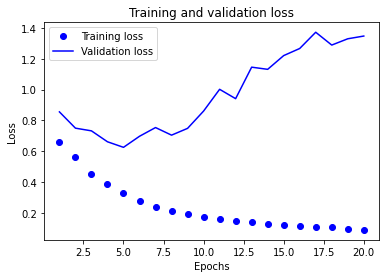

In [20]:


history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

